# Question 1

In [19]:
import numpy as np

In [20]:
def tanh(x):
    return np.tanh(x)


def tanh_grad(x):
    return 1 - np.tanh(x) ** 2


class NN():
    def __init__(self,architecture, learning_rate=0.1, activation=lambda x: x, activation_grad=lambda x: 1):
        '''This is a fully connected NN. The architecture is a list, 
        with each element specifying the number of nodes in each layer'''
        self.arch = architecture
        self.num_layers = len(self.arch) - 1
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.init_weights()
        
        
    def init_weights(self):
        np.random.seed(0) # don't modify this. GSI uses this for checking outputs
        self.weights = []
        self.biases= []
        for n in range(self.num_layers):
            self.weights.append(np.random.random((self.arch[n], self.arch[n+1])))
            self.biases.append(np.random.random((1, self.arch[n + 1])))

        
    def feed_forward(self, X):
        self.a_ns = []
        self.z_ns = []
        self.a_ns.append(X)
        for n in range(self.num_layers):
            z_n = np.dot(self.a_ns[-1], self.weights[n]) + self.biases[n]
            
            self.z_ns.append(z_n)
            self.a_ns.append(self.activation(z_n))

        return self.a_ns[-1]
            
    def loss_func(self, X, y):
        feed_forward = self.feed_forward(X)
        loss = np.mean((feed_forward - y) ** 2) * 0.5
        return loss
    
    
    def calc_layer_errors(self, X, y):
        feed_forward = self.feed_forward(X)

        self.layer_errors = []
        error_last_layer = (feed_forward - y) * self.activation_grad(self.z_ns[-1]) * 0.5
        self.layer_errors.append(error_last_layer)


        for i in range(self.num_layers - 2, -1, -1):
            error = self.activation_grad(self.z_ns[i]) * np.dot(self.layer_errors[-1], self.weights[i+1].T)
            self.layer_errors.insert(0, error)
        return self.layer_errors

    def calc_grads(self, X, y):
        self.calc_layer_errors(X, y)
        self.biases_grad, self.weights_grad = [], []
        
        for i in range(self.num_layers):
            if i == 0:
                wg = np.dot(X.T, self.layer_errors[i]) / len(X)
            else:
                wg = np.dot(self.a_ns[i].T, self.layer_errors[i]) / len(X)
            self.weights_grad.append(wg)
            
            bg = np.mean(self.layer_errors[i], axis=0, keepdims=True)
            self.biases_grad.append(bg)

            

        
    def back_prop(self, X, y):
        self.calc_grads(X, y)
        for i in range(self.num_layers):
            self.biases[i] -= self.lr * self.biases_grad[i]
            self.weights[i] -= self.lr * self.weights_grad[i]
    

## (a)

In [21]:
nn = NN([6, 2, 2], 0.1, tanh, tanh_grad)
# print the initialized weights
print(nn.weights)
print("\nBiases:", nn.biases)

[array([[0.5488135 , 0.71518937],
       [0.60276338, 0.54488318],
       [0.4236548 , 0.64589411],
       [0.43758721, 0.891773  ],
       [0.96366276, 0.38344152],
       [0.79172504, 0.52889492]]), array([[0.07103606, 0.0871293 ],
       [0.0202184 , 0.83261985]])]

Biases: [array([[0.56804456, 0.92559664]]), array([[0.77815675, 0.87001215]])]


## (b)

*For debugging*: if you use `np.random.random` to initialize weights and biases and set `np.random.seed(0)`. You will get `[[0.64027023 0.25119984]]` as the prediction

In [22]:
# print the prediction
input = np.array([[-1, 1, -1, -1, 1, -1]])
res = nn.feed_forward(input)
print(res)


[[0.64027023 0.25119984]]


## (c)

*Hint*: For the definition of layer errors, you can refer to the matrial in bCourses: `Files > Homework > HW3 > Guide_ANN.pdf`. You will use these errors in back-propagation.

*For debugging*: `[array([[0.08505865, 0.23282824]]), array([[0.48392403, 0.58612371]])]` are errors for two layers.

In [23]:
# print layer errors
layer_outputs = []
observed = np.array([-1, -1])
print(nn.calc_layer_errors(input, observed))


[array([[0.08505865, 0.23282824]]), array([[0.48392403, 0.58612371]])]


## (d)

In [24]:
# print updated weights & biases
nn.back_prop(input, observed)
print("Updated Weights:")
for i, weights in enumerate(nn.weights):
    print(f"Layer {i+1}:")
    print(weights)
print("\nUpdated Biases:")
for i, biases in enumerate(nn.biases):
    print(f"Layer {i+2}:")
    print(biases)

Updated Weights:
Layer 1:
[[0.55731937 0.73847219]
 [0.59425751 0.52160036]
 [0.43216066 0.66917694]
 [0.44609308 0.91505582]
 [0.9551569  0.3601587 ]
 [0.8002309  0.55217774]]
Layer 2:
[[0.07428843 0.09106854]
 [0.05552456 0.87538229]]

Updated Biases:
Layer 2:
[[0.5595387  0.90231381]]
Layer 3:
[[0.72976435 0.81139978]]


# Question 2

**If you want, you can read the following material to help you with the code!**

Let's denote $a$ as the output of our simple perceptron model.

$$ \mathbf{a} = \sigma(\mathbf{z}) = \sigma(\mathbf{Xw+b}) $$

where $X\in \mathbb{R}^{N_{bz}\times N_f}$ is the input data, $N_{bz}$ is the batch size (i.e. number of samples in one calculation) and $N_f$ is the dimension of input features. $\mathbf{w}\in \mathbb{R}^{N_f\times N_o}$ is the weights matrix and $\mathbf{b}\in \mathbb{R}^{N_o}$ is the biases. $N_o$ is the dimension of outputs. $\sigma$ is the activation function.

The loss function is defined as half of the mean squared error (MSE) bewteen predicted values $\mathbf{a}$ and the ground truth $\mathbf{O}$:

$$ C = \frac{1}{2}\mathrm{MSE}(\mathbf{a, O}) = \frac{1}{2N_{bz}N_o}\sum_{m}^{N_{bz}}\sum_{i}^{N_o}(a_{mi}-O_{mi})^2$$

Using the chain rule to calculate the gradient of weights and biases. First define

$$ \boldsymbol{\delta} = \frac{\partial C}{\partial \mathbf{z}} = \frac{\partial C}{\partial \mathbf{a}}\odot \sigma'(z) = \frac{1}{N_{bz}N_o}(\mathbf{a}-\mathbf{O})\odot\sigma'(\mathbf{z})$$

where $\odot$ is elementwise product.

$$ \frac{\partial C}{\partial \mathbf{w}} =  \mathbf{X}^T\frac{\partial C}{\partial \mathbf{z}} = \mathbf{X}^T\boldsymbol{\delta}$$

$$ \frac{\partial C}{\partial \mathbf{b}} =  \sum_{m}^{N_{bz}}\boldsymbol{\delta}_m$$

where $\boldsymbol{\delta}_m$ is the $m$-th row of matrix $\boldsymbol{\delta}$.

In [25]:
class SimplePerceptron():
    """
    Implementation of simple perceptron regressor
    """
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        learning_rate=0.0001,
        activation=lambda x: x,
        activation_grad=lambda x: 1
    ):
        """
        Initialize a simple perceptron regressor
        
        Parameters
        ----------
        input_dim: int
            Input dimension
        output_dim: int
            Output dimension
        learning_rate: float
            Learning Rate
        activation: Callable
            Activation function
        activation_grad: Callable
            Activation function's first derivative
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.weights = np.random.random((input_dim, output_dim))
        self.biases = np.random.random(output_dim)

    def predict(self, X):
        """
        Get predicted values of given input
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        
        Returns
        -------
        y: numpy.ndarray
            Output, shape (n_samples, output_dim)
        """
        # Convert rank-1 array to rank-2
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        
        # Check that the dimension of accepted input data is the same as expected
        dim = X.shape[1]
        if dim != self.input_dim:
            raise Exception(f"Expected input size {self.input_dim}, accepted {dim}")
        
        self.z = np.dot(X, self.weights) + self.biases
        self.a = self.activation(self.z)
        return self.a
    
    def fit(self, X, y):
        """
        Fit the model by doing an steepest descent step
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        """        
        self.predict(X)
        
        errors = (self.a - y) * self.activation_grad(self.z) / y.size   #shape (n_samples, output_dim) 
        weights_grad = np.dot(X.T, errors)                              #shape (input_dim, ouput_dim)
        bias_grad = np.sum(errors, axis=0)                              #shape (output_dim,)

        # Update weights and biases from the gradient
        # just do a simple gradient descent
        self.weights -= self.lr * weights_grad
        self.biases -= self.lr * bias_grad
        
    def train_one_epoch(self, X, y, batch_size=32):
        """
        Train the model for one epoch
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        batch_size: int
            Batch size
        """
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for i in range(0, X.shape[0], batch_size):
            batch = indices[i: i+batch_size]
            self.fit(X[batch], y[batch])

    def evaluate(self, X, y):
        """
        Get the loss function with given data
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        
        Returns
        -------
        L: float
            Loss function value.
        """
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        y_pred = self.predict(X)
        # mean squared error
        return np.mean((y_pred - y) ** 2)
    
    def get_weights(self):
        """
        Get weights and biases
        """
        return self.weights.copy(), self.biases.copy()
    
    def set_weights(self, weights, biases):
        """
        Set weights and biases
        """
        self.weights = weights
        self.biases = biases

## (a)

*Hint: Think about what activation function in the SimplePerceptron model should be used to perform a logistic regression?*

One-dimension logistic regression expression:

$$ y = \frac{1}{1+e^{-(ax+b)}} $$

In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
data = pd.read_csv('Datasets/titanic.csv')
data = data.dropna()

categorical_features = data[['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
survival_status = data[['Survived']]
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(categorical_features).toarray()
survival_encoded = encoder.fit_transform(survival_status).toarray()

print("Categories:\n", categorical_encoded)
print("Survival status:\n", survival_encoded)



Categories:
 [[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]]
Survival status:
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0

## (b)

Here, we will do the following things:

+ Split the data to $k$-folds, use the $k-1$ folds for training and the other fold for testing
+ In each fold, further split the training data ($k-1$ folds of the whole dataset) by 80\%/20\%. Use the 80\% to train the model in certain epochs and use the 20\% as a validation set to determine the best model during training.
+ For each fold, plot the validation loss against training
+ For each fold, report the mean squared error of the total training set (the $k-1$ fold data) and the test set (the other fold data)  

In [27]:
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np

def KFoldCrossValidation(
    k, X, y, epochs, draw_curve=True, learning_rate=0.0001, 
    activation=lambda x: x, activation_grad=lambda x: 1,
    verbose=True
):
    """
    K-Fold Validation
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    draw_curve: bool
        Whether to draw the validation loss against training steps
    learning_rate: float
        Learning rate
    activation: Callable
        Activation function
    activation_grad: Callable
        Gradient of activate function
    verbose: bool
        Whether to print information
    
    Returns
    ------
    model: list
        List of k models
    """
    # Reshape the X,y if they are rank-1
    if len(X.shape) == 1:
        X = X.reshape((-1, 1))
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    
    # do a 5-fold validation
    kf = KFold(n_splits=k)
    
    if draw_curve:
        n_row, n_col = int(np.ceil(k / 3)), 3
        fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row), constrained_layout=True)
        axes = axes.flatten()
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(X)):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        # define you models here
        model = SimplePerceptron(input_dim, output_dim, learning_rate, activation, activation_grad)
        
        # futher split the X_train by 80%/20%
        # use train_test_split function in sklearn
        X_train_in, X_val, y_train_in, y_val = train_test_split(X_train, y_train, test_size=0.2)
        
        lowest_val_err = np.inf
        val_err_list = []
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_one_epoch(X_train_in, y_train_in)
            val_err = model.evaluate(X_val, y_val)
            val_err_list.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights, biases = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        if verbose:
            print("Number of epochs with lowest validation:", np.argmin(val_err_list))
        model.set_weights(weights, biases)
        models.append(model)

        # Report MSE on X_train and X_test
        train_err = model.evaluate(X_train, y_train)
        train_err_list.append(train_err)
        test_err = model.evaluate(X_test, y_test)
        test_err_list.append(test_err)
        
        if draw_curve:
            axes[i].plot(np.arange(epochs), np.log10(val_err_list), label='Validation loss')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel('Log Loss')
            axes[i].legend()
            axes[i].set_title(f"Epoch {i}")
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)}+/-{np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)}+/-{np.std(test_err_list)}")
    
    return models

Number of epochs with lowest validation: 2582


Number of epochs with lowest validation: 4982
Number of epochs with lowest validation: 1443
Number of epochs with lowest validation: 4998
Number of epochs with lowest validation: 3487
Final results:
Training error: 0.12778737674083654+/-0.02770040001834124
Testing error: 0.5494929936374364+/-0.05799171569291407


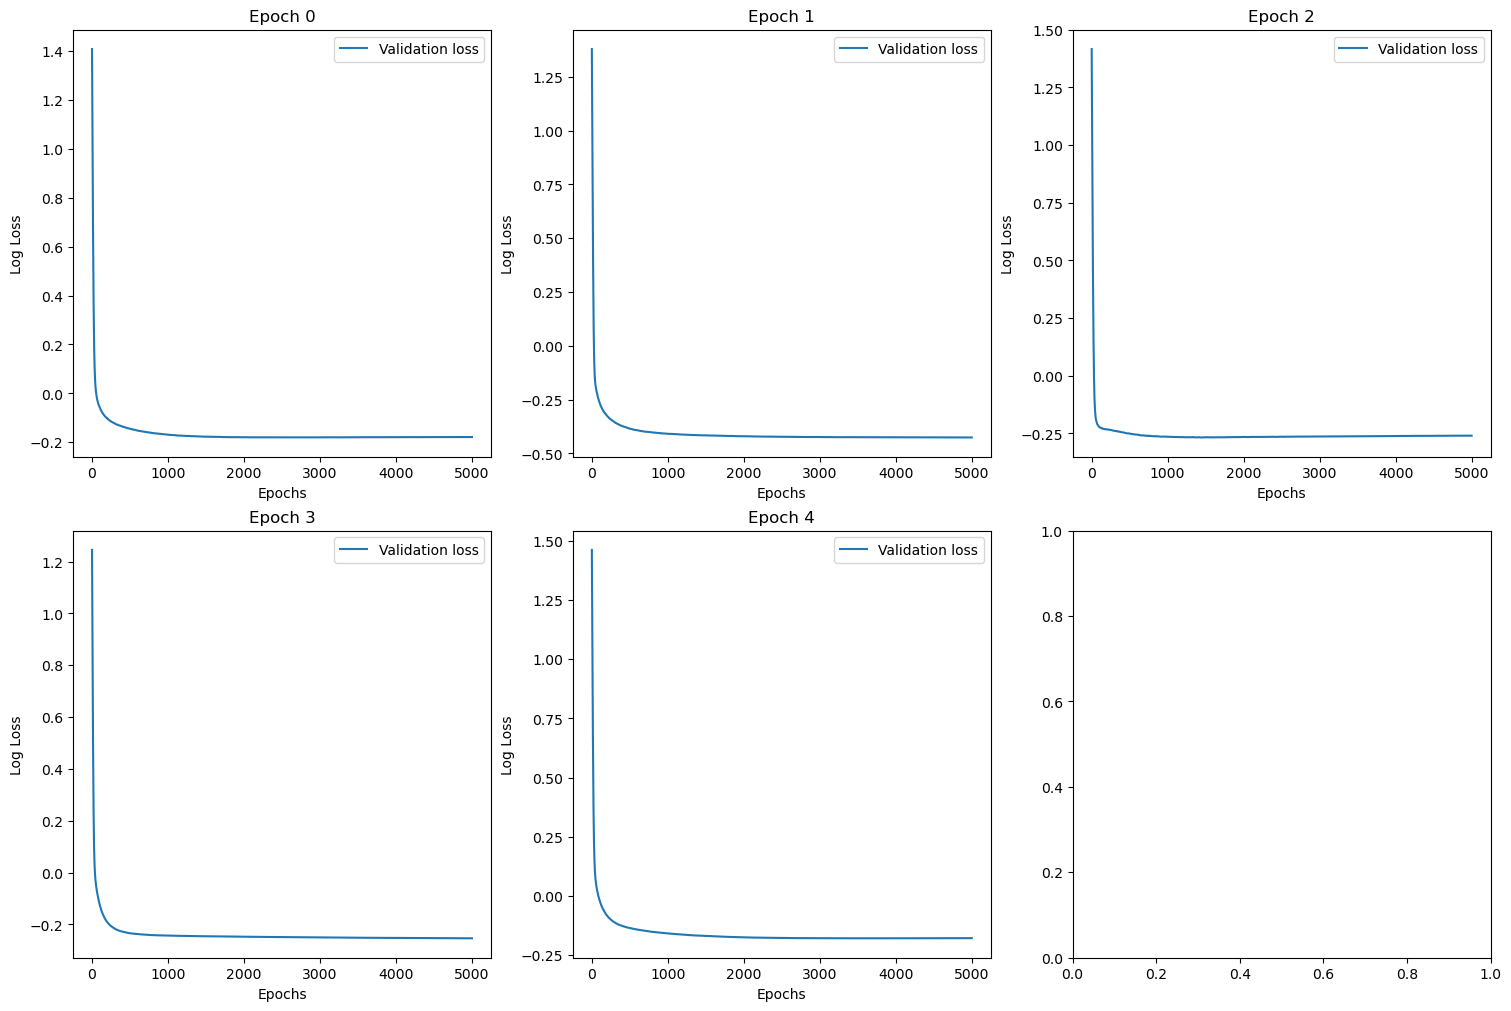

In [28]:
result = KFoldCrossValidation(k=5, X=categorical_encoded, y=survival_encoded, learning_rate=0.01, epochs=5000)
# Increased learning rate by factor of 100 b/c # of epochs was too large.

Number of epochs with lowest validation: 1273
Number of epochs with lowest validation: 313
Number of epochs with lowest validation: 4527
Number of epochs with lowest validation: 99
Number of epochs with lowest validation: 2091
Final results:
Training error: 0.220847771525197+/-0.11948810742224968
Testing error: 0.4138085753766708+/-0.04664290890524221


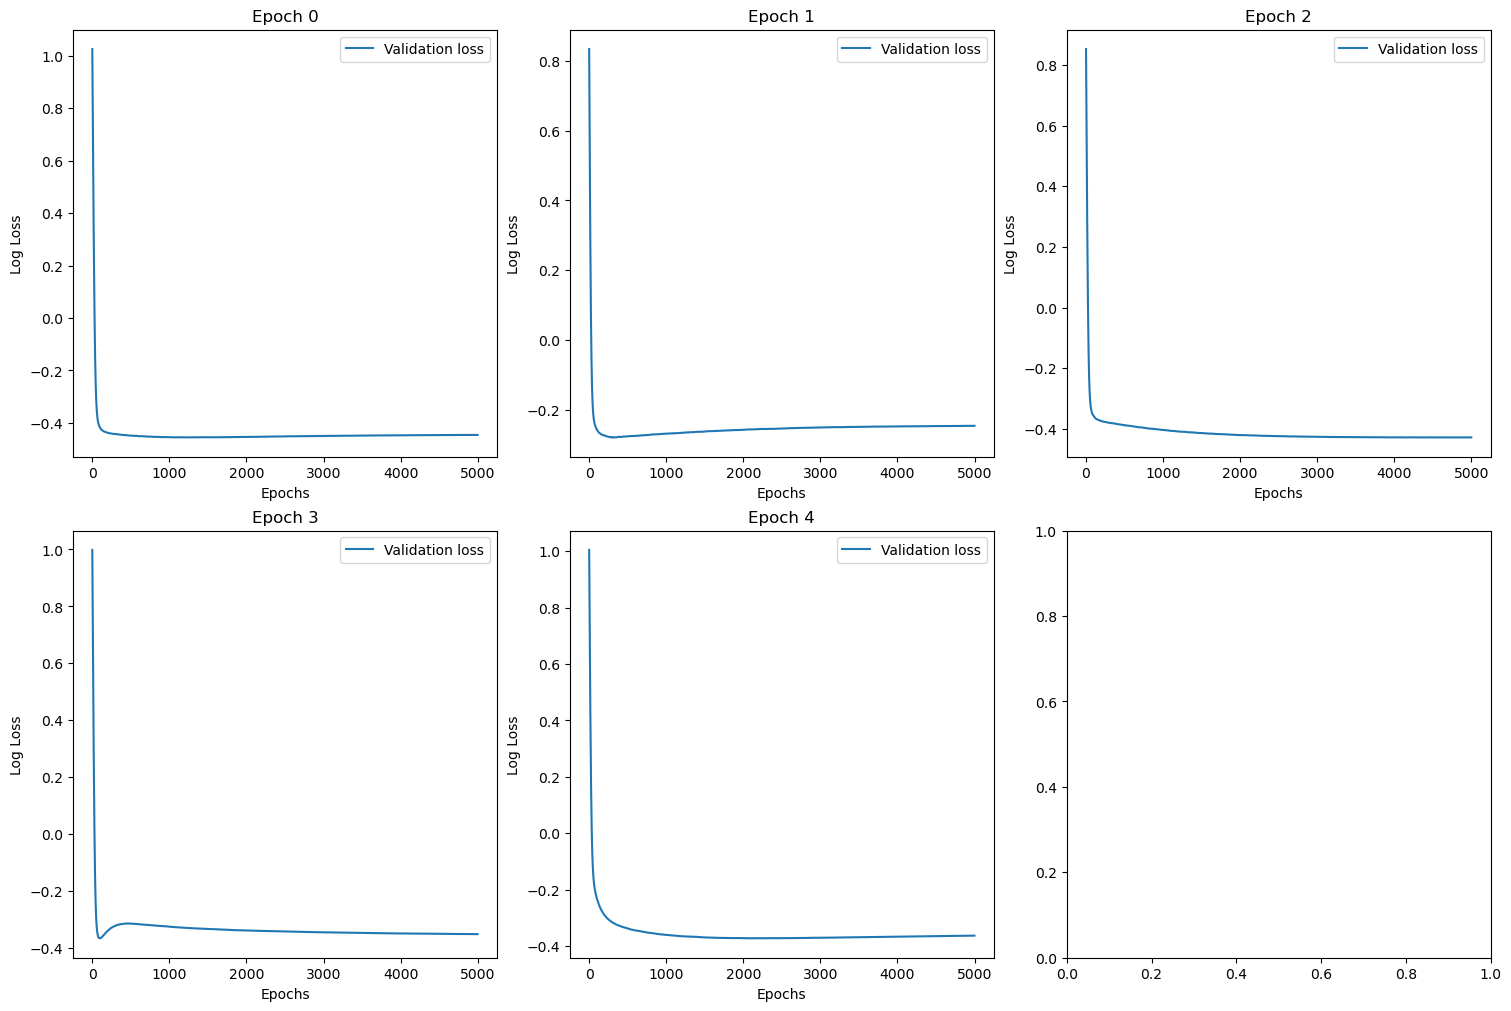

In [29]:
categorical_features = data[['Name','Sex','Age','SibSp','Parch','Ticket']]
categorical_encoded = encoder.fit_transform(categorical_features).toarray()
result = KFoldCrossValidation(k=5, X=categorical_encoded, y=survival_encoded, learning_rate=0.01, epochs=5000)


### Playing around with the features, we can see that the testing error went down when excluding some of the others.

# Question 3

## (a)

**Note**: `KFoldCrossValidation` returns a model list, just pick any one of them (for example, the first) for prediction on test dataset.

In [30]:
def generate_X(number, boundary):
    x = (np.random.random(number) * 2 - 1) * boundary
    return x
    
def generate_data(number, stochasticity=0.2):
    x = generate_X(number, 10)
    ratio = generate_X(number, stochasticity) + 1
    y = 3 * np.sin(x) * ratio + 5
    return x, y

In [31]:
def show_correlation(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    r = [
        np.min([np.min(y_pred), np.min(y_true)]), 
        np.max([np.max(y_pred), np.max(y_true)])
    ]
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    plt.scatter(y_pred, y_true, s=5)
    ax.plot(r, r, color='red')
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Ground truth")
    corr = np.corrcoef([y_pred, y_true])[1, 0]
    print("Correlation coefficient:", corr)

def show_plot(x, y_true, y_pred=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.scatter(x, y_true, s=0.5, label='Ground Truth')
    if y_pred is not None:
        ax.scatter(x, y_pred, s=0.5, label="Predicted")
    ax.legend()

Number of epochs with lowest validation: 500
Number of epochs with lowest validation: 357
Number of epochs with lowest validation: 973
Number of epochs with lowest validation: 1581
Number of epochs with lowest validation: 412
Final results:
Training error: 4.186358549902176+/-0.028746342363722907
Testing error: 4.190305927721801+/-0.13214819512802167


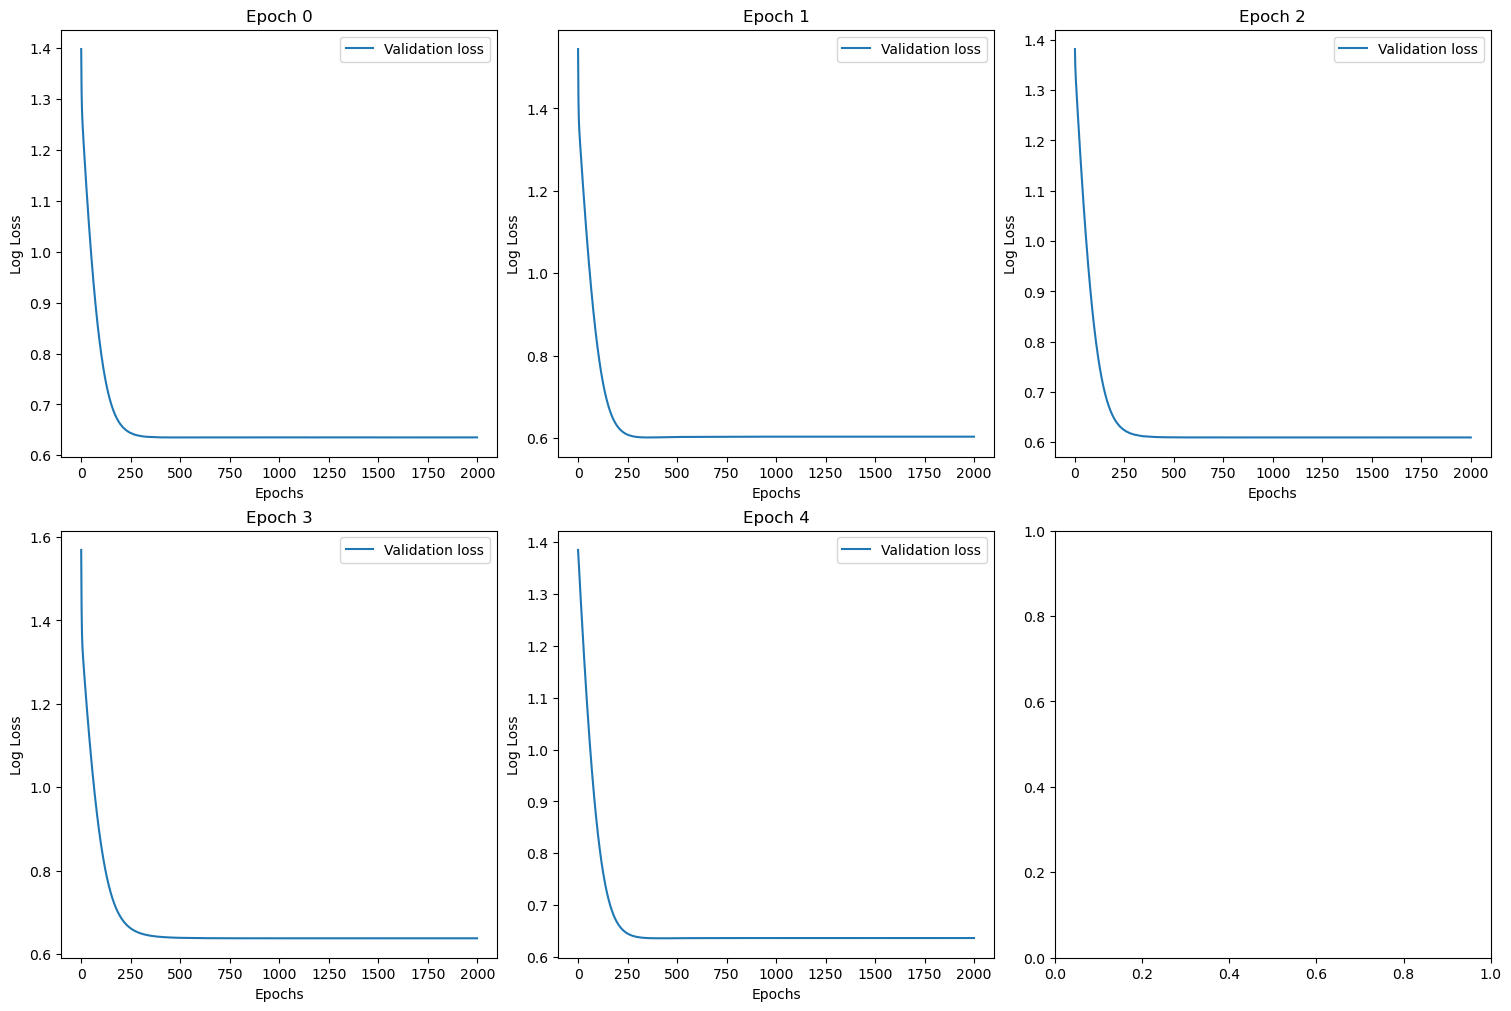

In [32]:
X, y = generate_data(5000)
kfold_res = KFoldCrossValidation(5, X, y, 2000)

### Q. How well is the prediction?  A. The correlation coefficient is low (nearly 0), indicating that there is almost no correlation.  There is also significant variance between the line of regression and the predictions in blue.  This does not fit the prediction well.  Our simple perceptron cannot learn non-linear (i.e., random) data.

Correlation coefficient: 0.20152663573049093


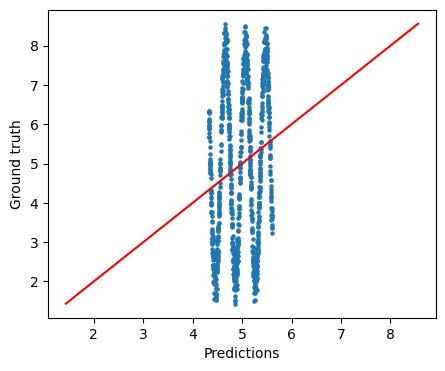

In [33]:
X_test, y_test = generate_data(1000)
show_correlation(kfold_res[0].predict(X_test), y_test)

## (b)

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse

def KFoldCrossValidationMLP(
    k, X, y, epochs, 
    learning_rate=0.01, 
    activation='tanh',
    hidden_layers=(8,),
    verbose=True
):
    """
    K-Fold Validation for MLPRegressor
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    kwargs: keyword arguments
        Arguments to init a SimplePerceptron model. i.e. learning_rate, activation, activation_grad
    
    Returns
    ------
    model: SimplePerceptron
        The best model
    """
    # MLPRegressor takes 2D array for features
    # and 1D array for labels if the dimension of output is 1
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)

    # do a 5-fold validation
    kf = KFold(n_splits=k, shuffle=True)
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(np.arange(X.shape[0]))):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        model = MLPRegressor(
            max_iter=epochs,
            activation=activation, 
            learning_rate_init=learning_rate,
            hidden_layer_sizes=hidden_layers,
            early_stopping=True, validation_fraction=0.2, learning_rate='constant', 
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Report MSE on X_train and X_test
        y_train_pred = model.predict(X_train)
        train_err = mse(y_train_pred, y_train)
        train_err_list.append(train_err)
        
        y_test_pred = model.predict(X_test)
        test_err = mse(y_test_pred, y_test)
        test_err_list.append(test_err)
        if verbose:
            print(f"Train error: {train_err}, Test error: {test_err}")
        
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)}+/-{np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)}+/-{np.std(test_err_list)}")
    
    return models[np.argmin(test_err_list)]

Train error: 0.40129027814608176, Test error: 0.36695092967927906
Train error: 0.38969160520180474, Test error: 0.443567121017784
Train error: 2.4223839904947324, Test error: 2.1783343991009287
Train error: 2.373705504874624, Test error: 2.397093204230163
Train error: 1.9879079902666117, Test error: 1.977329582813215
Final results:
Training error: 1.514995873796771+/-0.9263942082543725
Testing error: 1.4726550473682738+/-0.8819148707313358
Correlation coefficient: 0.9586649232905609


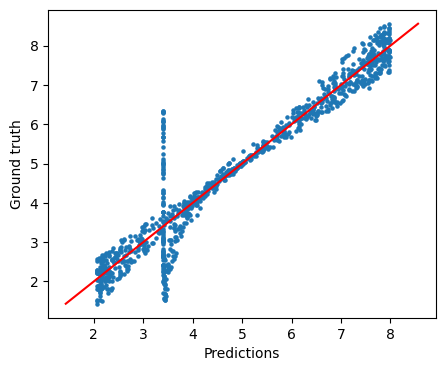

In [35]:
# X and y are the same from the simple perceptron, so that we can visualize the difference.
mlp = KFoldCrossValidationMLP(5, X, y, epochs=2000)
show_correlation(mlp.predict(X_test.reshape(-1, 1)), y_test)

### The correlation is much, much better.  The coefficient is nearly 1, which would be perfect.  The problem with the simple perceptron is that we applied a simple sigmoid function, when MLPs generally use RELU functions.  In addition, we apply multiple neurons for our single-layer MLP, which helps inform our data better.

## (c)

Train error: 0.06396848807921977, Test error: 0.0629004850517194
Train error: 0.3809098605284364, Test error: 0.4363622513038075
Train error: 0.06829921209485969, Test error: 0.06383422638986944
Train error: 0.06035198585104076, Test error: 0.06540711549002327
Train error: 0.06548099882977652, Test error: 0.06956776700297387
Final results:
Training error: 0.12780210907666661+/-0.1265798559561522
Testing error: 0.1396143690476787+/-0.14839150823484484
Correlation coefficient: 0.9928888673996409


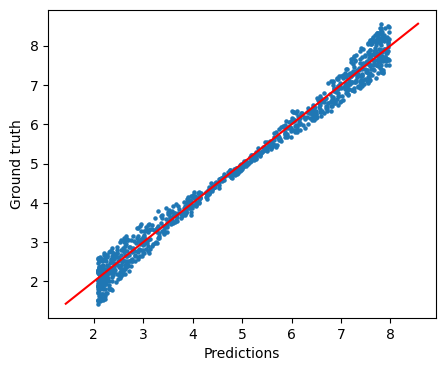

In [36]:
mlp = KFoldCrossValidationMLP(5, X, y, hidden_layers=(8, 4), epochs=2000)
show_correlation(mlp.predict(X_test.reshape(-1, 1)), y_test)

### A good MLP usually has 2-3 layers.  Here, I give it a decent amount of neurons per layer, with 2 layers.  I was able to achieve a better correlation coefficient.